# Visualizing intermediate activations

In [429]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [430]:
from keras.preprocessing import image
import numpy as np
img_path= 'D:/Sunil/sunil_conda/t81_558_deep_learning-master/t81_558_deep_learning-master/data/dog.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


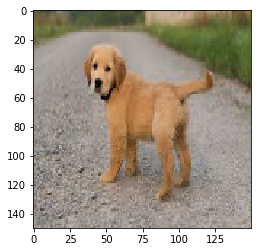

In [431]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [432]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [433]:
activations = activation_model.predict(img_tensor)

In [434]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


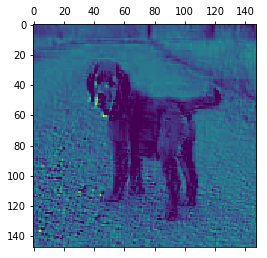

In [435]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

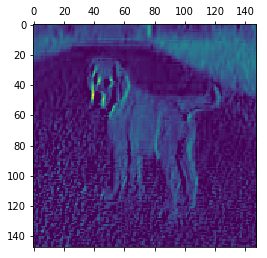

In [436]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

C:\Users\bdhooda\AppData\Local\conda\conda\envs\dfhdfh\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


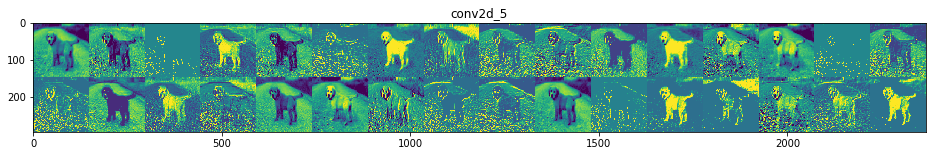

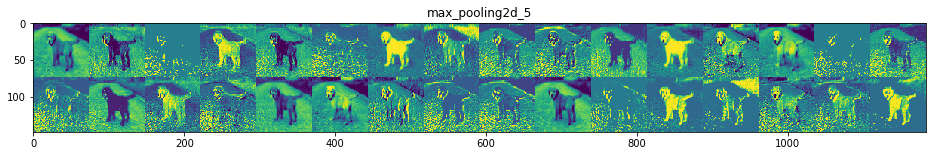

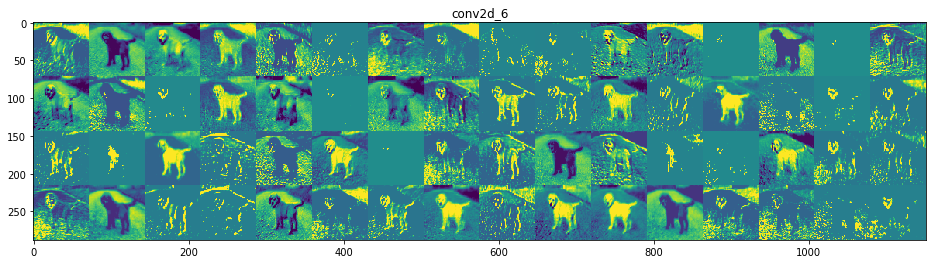

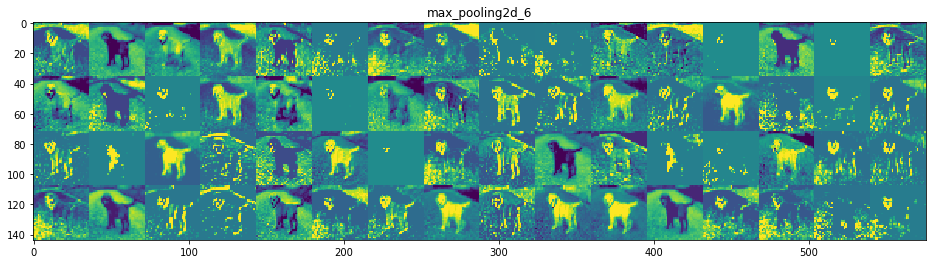

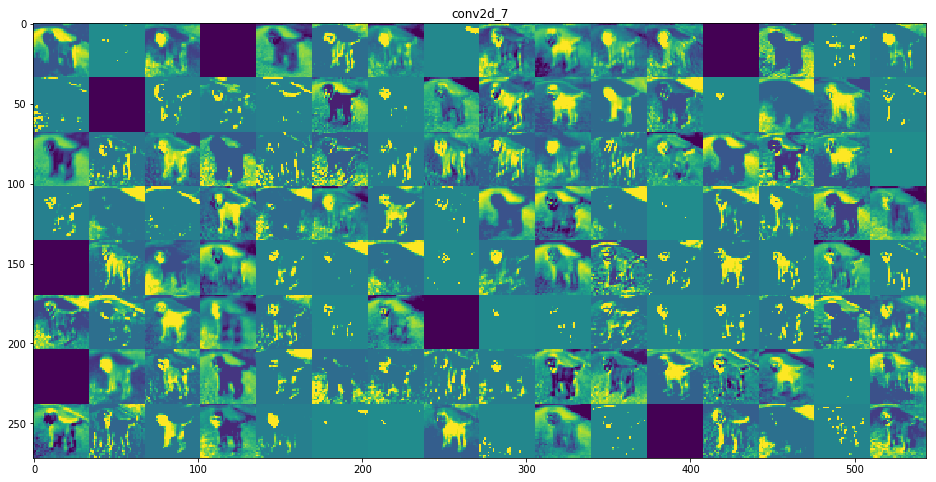

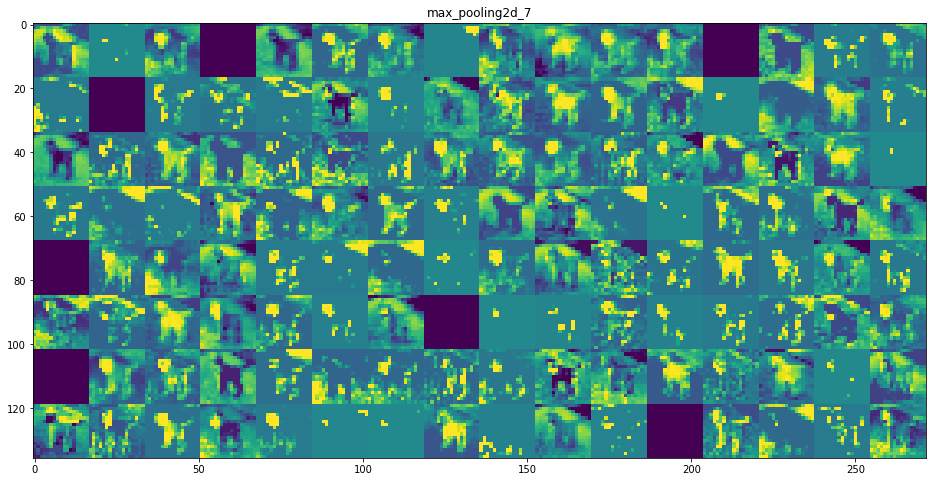

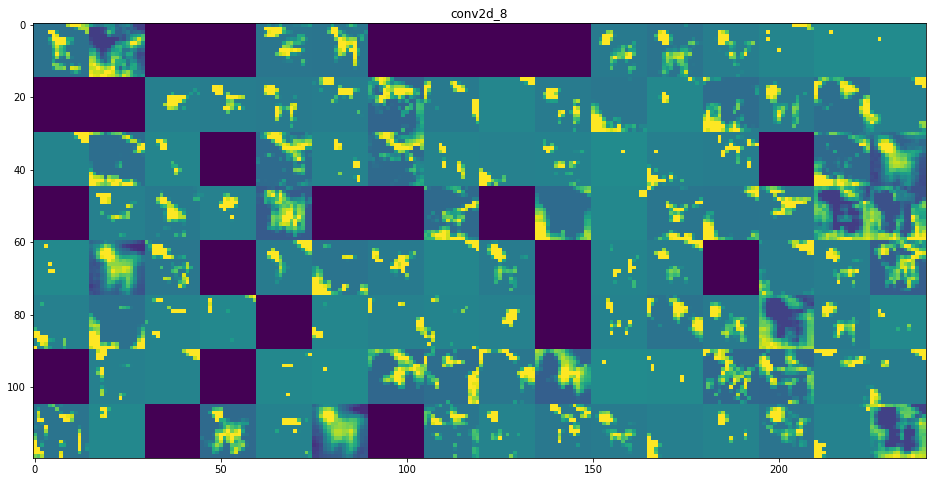

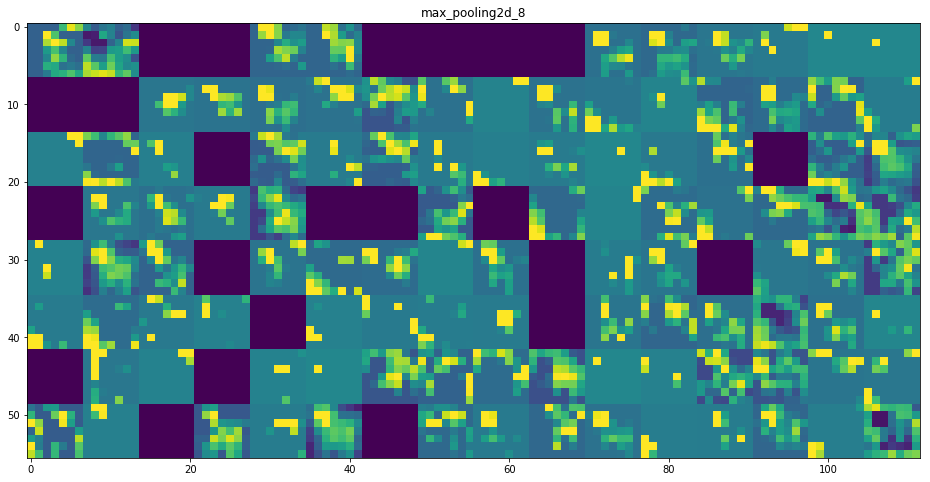

In [437]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()


# Visualizing convnet filters

In [438]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

KeyboardInterrupt: 

In [ ]:
grads = K.gradients(loss, model.input)[0]

In [ ]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [ ]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [ ]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:

plt.imshow(generate_pattern('block4_conv1', 0))
plt.show()

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

# Visualizing heatmaps of class activation

In [441]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [442]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [473]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
source = 'butterfly'
img_path = 'D:/Sunil/sunil_conda/t81_558_deep_learning-master/t81_558_deep_learning-master/data/'+str(source)+'.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [474]:
preds = model.predict(x)

In [475]:
output= decode_predictions(preds, top=3)[0]

In [476]:
output

[('n02280649', 'cabbage_butterfly', 0.53186625),
 ('n02281787', 'lycaenid', 0.30728266),
 ('n02281406', 'sulphur_butterfly', 0.1433466)]

In [477]:
percent=round(output[0][2]*100)

In [478]:
print('The image is '+output[0][1]+' and the propability of the image is '+str(percent)+'%')

The image is cabbage_butterfly and the propability of the image is 53.0%


In [479]:
label = np.argmax(preds[0])

In [480]:
pic= model.output[:, label]

In [481]:
last_conv_layer = model.get_layer('block5_conv3')

In [482]:
grads = K.gradients(pic, last_conv_layer.output)[0]

In [483]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [484]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

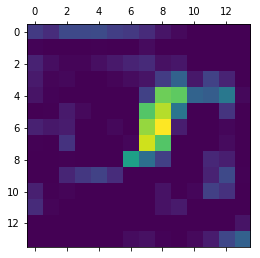

In [485]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [486]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('D:/Sunil/sunil_conda/t81_558_deep_learning-master/t81_558_deep_learning-master/data/'+str(source)+'_imposed.jpg', superimposed_img)

True

In [487]:
model.save('image_classification_all_objects.json')

In [488]:
model.save('image_classification_all_objects.h5')